In [49]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear


In [ ]:
# Load the dataset
data = pd.read_csv("../datasets/diabetes[1].csv")
X = torch.tensor(data.iloc[:, :-1].values, dtype=torch.float32)
# X=  torch.cat([X for i in range(1, 2)], dim=1)
y = torch.tensor(data.iloc[:, -1].values, dtype=torch.float32).view(-1, 1)

In [ ]:
# Define the training function
def train_model(model, criterion, optimizer, X, y, epochs=200):
    model.train()
    losses = []
    for _ in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses


# Define the timing function
def time_model(model, X, y, criterion):
    model.eval()
    with torch.no_grad():
        # Time inference
        torch.cuda.synchronize()
        start_time = time.perf_counter()
        outputs = model(X)
        inference_time = time.perf_counter() - start_time

    # Time backpropagation
    model.train()
    outputs = model(X)
    loss = criterion(outputs, y)
    torch.cuda.synchronize()
    start_time = time.perf_counter()
    loss.backward()
    backprop_time = time.perf_counter() - start_time

    return inference_time, backprop_time

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(LinearModel, self).__init__()
        self.layer1 = Linear(in_features=input_dim, out_features=hidden_dim)
        self.relu = nn.ReLU()
        self.layer2 = Linear(in_features=hidden_dim, out_features=output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x

In [53]:
# Initialize models, criterion, and optimizers
input_dim = X.shape[1]
output_dim = 1

linear_model = LinearModel(input_dim=input_dim, output_dim=output_dim).cuda()

In [54]:
criterion = nn.BCELoss()
linear_optimizer = optim.Adam(linear_model.parameters(), lr=0.01)

linear_losses = train_model(
    linear_model, criterion, linear_optimizer, X.cuda(), y.cuda()
)

In [55]:
# Time both models
linear_inference_time, linear_backprop_time = time_model(
    linear_model, X.cuda(), y.cuda(), criterion
)

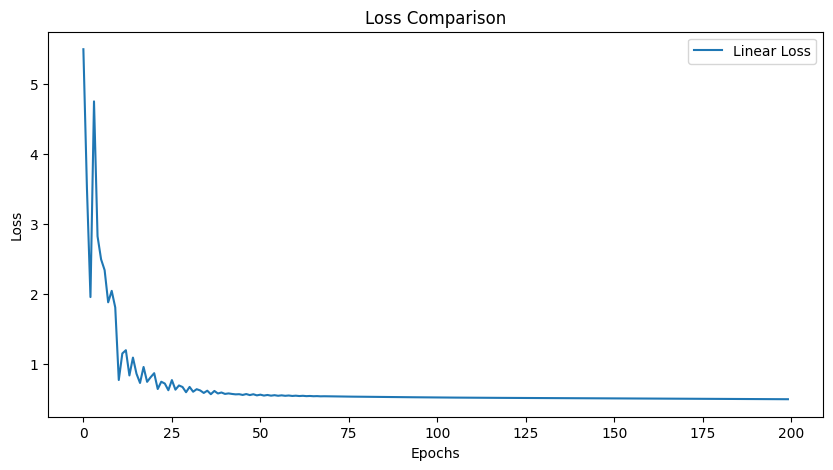

In [56]:
# Plot the loss graph
plt.figure(figsize=(10, 5))
plt.plot(linear_losses, label="Linear Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.show()